In [13]:
%load_ext autoreload


In [14]:
%autoreload 2


# EDA on customer loans


## Code

Importing modules

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from scipy import stats
from scipy.stats import yeojohnson, zscore
import matplotlib.pyplot as plt
import plotly.express as px

Importing classes

In [2]:
from DataFrameTransform import DataFrameTransform
from DataInfo import DataFrameInfo
from DataTransform import DataTransform
from Plotter import Plotter

Importing data

In [3]:
df = pd.read_csv('loan_payments.csv')
df = pd.DataFrame(df)

First I need to convert all the columns to the right data type

In [4]:
columns_to_bool = ['payment_plan']
bool_dict = {columns_to_bool[0]: ('y', 'n')}
columns_to_int = ['term', 'employment_length']
columns_to_cat = ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'loan_status', 'payment_plan', 'purpose', 'application_type', 'policy_code']
columns_to_date = ['issue_date', 'earliest_credit_line', 'last_payment_date', 'last_credit_pull_date']
date_format = '%b-%Y'

df_transform = DataTransform(df)
df_transform.convert_to_bool(bool_dict)
df_transform.convert_to_cat(columns_to_cat)
df_transform.convert_to_int(columns_to_int)
df_transform.convert_to_date(columns_to_date, date_format)
df_transform.df.info()
df = df_transform.df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54231 entries, 0 to 54230
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Unnamed: 0                   54231 non-null  int64         
 1   id                           54231 non-null  int64         
 2   member_id                    54231 non-null  int64         
 3   loan_amount                  54231 non-null  int64         
 4   funded_amount                51224 non-null  float64       
 5   funded_amount_inv            54231 non-null  float64       
 6   term                         49459 non-null  float64       
 7   int_rate                     49062 non-null  float64       
 8   instalment                   54231 non-null  float64       
 9   grade                        54231 non-null  category      
 10  sub_grade                    54231 non-null  category      
 11  employment_length            47079 non-nu

Checking null percent of each column

In [5]:
df_plot = Plotter(df)
high_nulls = df_plot.percent_of_nulls(50)[0]
imputer_nulls = df_plot.percent_of_nulls(50)[1]
print(imputer_nulls)
df_plot =df_plot.df.drop(high_nulls, axis=1)
df_plot = Plotter(df_plot)
df_plot.percent_of_nulls()
df = df_plot.df


funded_amount has 5.54 null percentage
term has 8.8 null percentage
int_rate has 9.53 null percentage
employment_length has 13.19 null percentage
collections_12_mths_ex_med has 0.09 null percentage
the columns with over 50% nulls are ['mths_since_last_delinq', 'mths_since_last_record', 'next_payment_date', 'mths_since_last_major_derog']
funded_amount has 5.54 null percentage
term has 8.8 null percentage
int_rate has 9.53 null percentage
employment_length has 13.19 null percentage
collections_12_mths_ex_med has 0.09 null percentage
the columns with over 50% nulls are ['mths_since_last_delinq', 'mths_since_last_record', 'next_payment_date', 'mths_since_last_major_derog']
['funded_amount', 'term', 'int_rate', 'employment_length', 'collections_12_mths_ex_med']
funded_amount has 5.54 null percentage
term has 8.8 null percentage
int_rate has 9.53 null percentage
employment_length has 13.19 null percentage
collections_12_mths_ex_med has 0.09 null percentage
the columns with over 50% nulls are

Dropped the columns with over 50% nulls

Now time to impute the nulls

In [6]:

df_imputer = DataFrameTransform(df)
medians_means = df_imputer.columns_to_mean_from_nulls(imputer_nulls)
median_imputees = medians_means[1]
mean_imputees = medians_means[0]
df = df_imputer.impute_missing_values(median_imputees, mean_imputees)

['funded_amount', 'term', 'int_rate', 'employment_length', 'collections_12_mths_ex_med']
['funded_amount', 'term', 'int_rate', 'employment_length', 'collections_12_mths_ex_med']


use Plotter to check that it has worked

In [7]:
print(df.head())
df_plot = Plotter(df)
df_plot.percent_of_nulls()

   Unnamed: 0        id  member_id  loan_amount  funded_amount  \
0           0  38676116   41461848         8000         8000.0   
1           1  38656203   41440010        13200        13200.0   
2           2  38656154   41439961        16000        16000.0   
3           3  38656128   41439934        15000        15000.0   
4           4  38656121   41439927        15000        15000.0   

   funded_amount_inv  term  int_rate  instalment grade  ... total_rec_int  \
0             8000.0  36.0      7.49      248.82     A  ...        512.21   
1            13200.0  36.0      6.99      407.52     A  ...        787.94   
2            16000.0  36.0      7.49      497.63     A  ...        824.54   
3            15000.0  36.0     14.31      514.93     C  ...        947.47   
4            15000.0  36.0      6.03      456.54     A  ...        770.93   

   total_rec_late_fee recoveries  collection_recovery_fee last_payment_date  \
0                 0.0        0.0                      0.0    

[[], []]

## Skew and Outliers

Now it's time to start viewing the data; firstly skew

/Users/jamespreston/Documents/aicore/EDA/Plotter.py:73: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  pyplot.tight_layout()


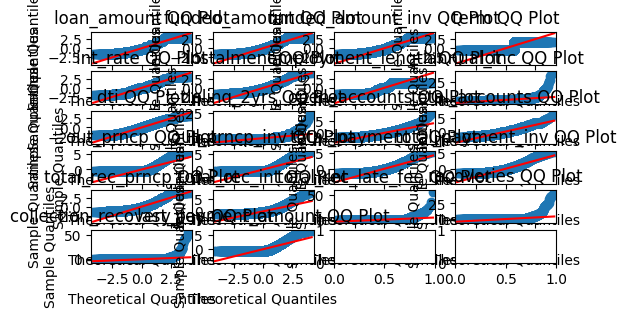

In [8]:
columns_that_should_be_skew_viewable = ['loan_amount','funded_amount','funded_amount_inv','term','int_rate','instalment','employment_length','annual_inc','dti','delinq_2yrs','mths_since_last_delinq','mths_since_last_record','open_accounts','total_accounts','out_prncp','out_prncp_inv','total_payment','total_payment_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_payment_amount','mths_since_last_major_derog']
for column in high_nulls:
    try:
        columns_that_should_be_skew_viewable.remove(column)
    except:
        pass
df_plot = Plotter(df)
df_plot.multi_qq_plot(columns_that_should_be_skew_viewable)
columns_with_skew = df_plot.skew_column_maker(columns_that_should_be_skew_viewable)
df_transform = DataFrameTransform(df)
list_of_imputations = df_transform.method_for_correction(columns_with_skew)

In [9]:
print(list_of_imputations)

[[], ['term', 'annual_inc'], ['delinq_2yrs', 'open_accounts', 'out_prncp', 'out_prncp_inv', 'total_payment', 'total_payment_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_payment_amount']]


In [10]:
df_transform.log_correcting(list_of_imputations[0])
df_transform.boxcox_correcting(list_of_imputations[1])
df_transform.yeo_correcting(list_of_imputations[2])
df = df_transform.df

In [11]:
df_plot = Plotter(df)
columns_with_potential_outliers = ['loan_amount', 'funded_amount', 'funded_amount_inv', 'term', 'int_rate', 'employment_length', 'annual_inc', 'dti']
df_zscore = df_plot.zscore_maker()
df_transform = DataFrameTransform(df_plot.df)
df_transform.zscore_dropper(df_zscore, columns_with_potential_outliers, 3)
df_plot = Plotter(df_transform.df)
null_columns = df_plot.percent_of_nulls()



int_rate has 0.04 null percentage
annual_inc has 0.37 null percentage
dti has 0.06 null percentage
the columns with over 50% nulls are []


Now time to look for overly corelated columns

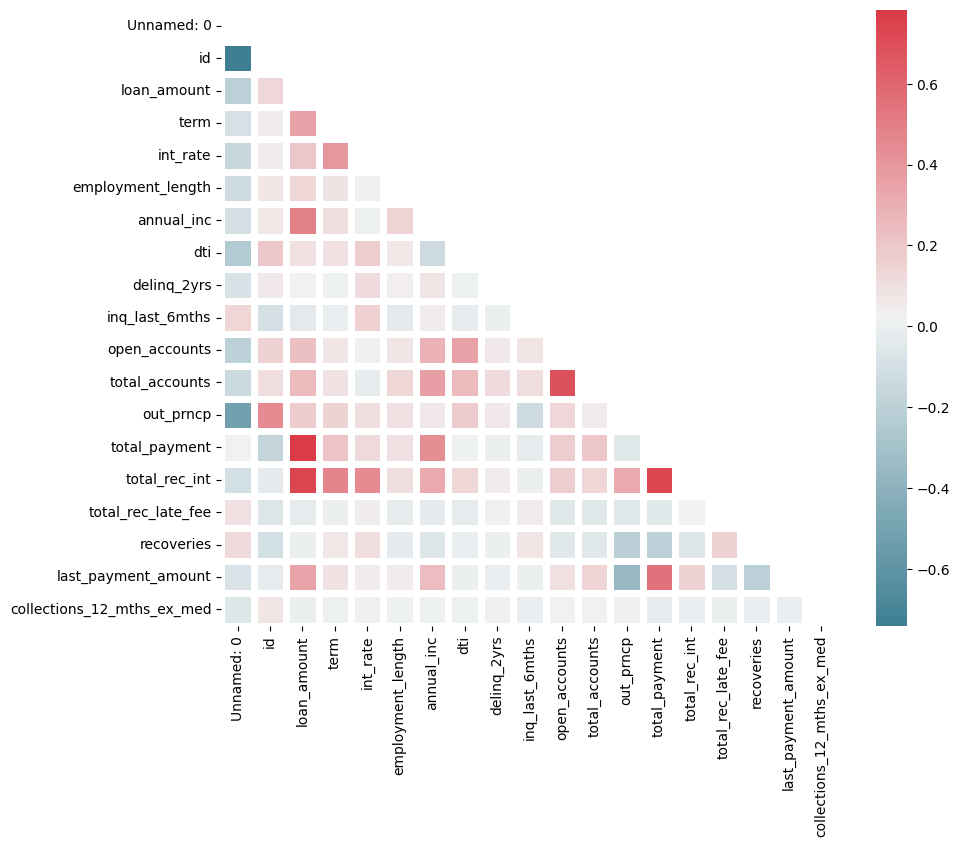

In [37]:
df = df_transform.df
numeric_cols = df_transform.columns_with_numeric()
df_plot = Plotter(df)
df_plot.correlated_vars(numeric_cols)
drop_cols = df_plot.columns_to_drop(numeric_cols)
df = df_transform.dropper(drop_cols)
df_transform = DataTransform(df)
df_transform.write_to_csv('imputed_and_nulls.csv')

## Current state of loans

In [40]:
df = pd.read_csv("imputed_and_nulls.csv",
                 parse_dates=['issue_date', 'last_payment_date'])

df['final_payment_date'] = df.apply(
    lambda row: row['issue_date'] + DateOffset(months=row['term']), axis=1)
df['total_to_pay'] = df['instalment'] * \
    df['term']

no_nill_invested = df['funded_amount_inv'] != 0

ValueError: Non-integer years and months are ambiguous and not currently supported.